In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline


# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.2f}".format

In [2]:
# Import the dataset.
train_df = pd.read_csv(filepath_or_buffer="https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

In [3]:
scale_factor = 1000.0

# Scale the training set's label.
train_df["median_house_value"] /= scale_factor 

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.00,5612.00,1283.00,1015.00,472.00,1.49,66.90
1,-114.47,34.40,19.00,7650.00,1901.00,1129.00,463.00,1.82,80.10
2,-114.56,33.69,17.00,720.00,174.00,333.00,117.00,1.65,85.70
3,-114.57,33.64,14.00,1501.00,337.00,515.00,226.00,3.19,73.40
4,-114.57,33.57,20.00,1454.00,326.00,624.00,262.00,1.93,65.50


Scaling ***median_house_value*** puts the value of each house in units of thousands. Scaling will keep loss values and learning rates in a friendlier range.

Although *scaling* a label is ***usually not essential***, ***scaling features in a multi-feature model usually is essential.***


#### ***Examine Data***

In [5]:
train_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00
mean,-119.56,35.63,28.59,2643.66,539.41,1429.57,501.22,3.88,207.30
std,2.01,2.14,12.59,2179.95,421.50,1147.85,384.52,1.91,115.98
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,15.00
25%,-121.79,33.93,18.00,1462.00,297.00,790.00,282.00,2.57,119.40
50%,-118.49,34.25,29.00,2127.00,434.00,1167.00,409.00,3.54,180.40
75%,-118.00,37.72,37.00,3151.25,648.25,1721.00,605.25,4.77,265.00
max,-114.31,41.95,52.00,37937.00,6445.00,35682.00,6082.00,15.00,500.00


* total_rooms, total_bedrooms, population, and households
> There is a huge gap between upper quantile and the max value.
> Especially in ***total_rooms*** and the ***population*** fields.

We can consider these values as outlier. And discard those from data. 

In [6]:
%%time

### Defining the model and training functions
#@title Define the functions that build and train a model
def build_model(my_learning_rate):
    """Create and compile a simple linear regression model."""
    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Describe the topography of the model.
    # The topography of a simple linear regression model
    # is a single node in a single layer.
    model.add(tf.keras.layers.Dense(units=1, 
                                  input_shape=(1,)))

    # Compile the model topography into code that TensorFlow can efficiently
    # execute. Configure training to minimize the model's mean squared error. 
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model        


def train_model(model, df, feature, label, epochs, batch_size = None, validation_split=.1):
    """Train the model by feeding it data."""

    # Feed the model the feature and the label.
    # The model will train for the specified number of epochs. 
    history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_split=validation_split)

    # Gather the trained model's weight and bias.
    weight = model.get_weights()[0]
    intercept = model.get_weights()[1] # the scalar where intercept the y-axis when the all weights are equal to zero.

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch
  
    # Isolate the error for each epoch.
    hist = pd.DataFrame(history.history)

#     # To track the progression of training, we're going to take a snapshot
#     # of the model's root mean squared error at each epoch. 
#     rmse = hist["root_mean_squared_error"]
    # Isolate the root mean squared error for each epoch.
    hist = pd.DataFrame(history.history)
    rmse = hist["root_mean_squared_error"]

    return  epochs, rmse, history.history # weight, intercept, epochs, rmse

print("Model functions are defined...")

Model functions are defined...
Wall time: 997 µs


In [7]:
%%time
#@title Define the plotting function

def plot_the_loss_curve(epochs, mae_training, mae_validation):
    """Plot a curve of loss vs. epoch."""

    plt.figure(figsize=(12,7))
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs[1:], mae_training[1:], label="Training Loss")
    plt.plot(epochs[1:], mae_validation[1:], label="Validation Loss")
    plt.legend()
  
    # We're not going to plot the first epoch, since the loss on the first epoch
    # is often substantially greater than the loss for other epochs.
    merged_mae_lists = mae_training[1:] + mae_validation[1:]
    highest_loss = max(merged_mae_lists)
    lowest_loss = min(merged_mae_lists)
    delta = highest_loss - lowest_loss
    print(delta)

    top_of_y_axis = highest_loss + (delta * 0.05)
    bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
    plt.ylim([bottom_of_y_axis, top_of_y_axis])
    plt.yticks(np.arange(bottom_of_y_axis, top_of_y_axis+.5, 5))
    plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.
Wall time: 0 ns


In [15]:
#@title Define Evaluation function
def evaluate(df, X, y, learning_rate=.01, epochs=3, batch_size=None, validation_rate=.2, evaluate_test_set = False, test_df=None):
    """
    Evaluates the ML process.
    X array like list of feature headers. ["feature_1", "feature_2", "feature_3", ...]
    y target variable's header.
    """
    # Invoke the functions to build and train the model.
    model = build_model(learning_rate)
    epochs, rmse, history = train_model(model, df, X, y, 
                                        epochs, batch_size, 
                                        validation_rate)
    
    
        
    plot_the_loss_curve(epochs, history["root_mean_squared_error"], 
                        history["val_root_mean_squared_error"])
    
    if evaluate_test_set:
        x_test = test_df[X]
        y_test = test_df[y]

        results = model.evaluate(x_test, y_test, batch_size=batch_size)
        print("*"*24)
        print("Test Results")
        print("*"*24)
        print("Loss: {},\nRMSE: {}".format(results[0], results[1]))
        print("*"*24)

Train on 13600 samples, validate on 3400 samples
Epoch 1/30
13600/13600 [==============================] - 0s 35us/sample - loss: 39290.4758 - root_mean_squared_error: 198.2182 - val_loss: 47688.9609 - val_root_mean_squared_error: 218.3780
Epoch 2/30
13600/13600 [==============================] - 0s 12us/sample - loss: 22544.8571 - root_mean_squared_error: 150.1494 - val_loss: 27756.0599 - val_root_mean_squared_error: 166.6015
Epoch 3/30
13600/13600 [==============================] - 0s 11us/sample - loss: 11929.4254 - root_mean_squared_error: 109.2219 - val_loss: 15026.1946 - val_root_mean_squared_error: 122.5814
Epoch 4/30
13600/13600 [==============================] - 0s 12us/sample - loss: 7178.0084 - root_mean_squared_error: 84.7231 - val_loss: 9547.2902 - val_root_mean_squared_error: 97.7102
Epoch 5/30
13600/13600 [==============================] - 0s 11us/sample - loss: 6513.7715 - root_mean_squared_error: 80.7079 - val_loss: 9340.8298 - val_root_mean_squared_error: 96.6480
Epoc

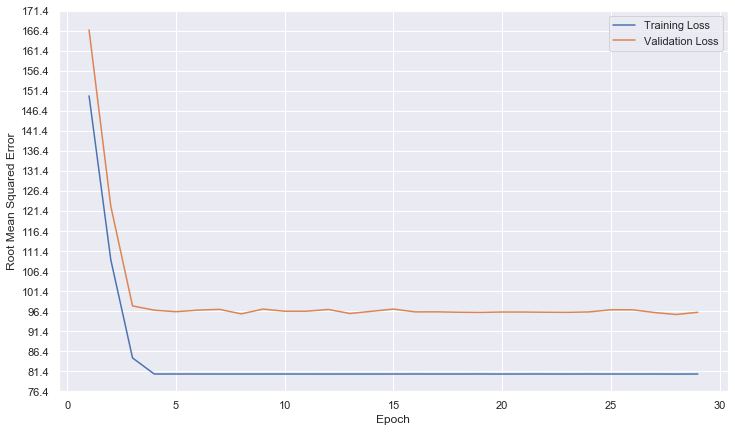

In [8]:
### Task 1 - Experimenting with Validation Split
evaluate(train_df, ["median_income"], "median_house_value", 0.08, 30, 100, .2)

By changing validation set size, we can get the expected results, Nearly equal train and validation loss.
as we can see the train and validation losses differ from each other. But why?

In [9]:
### Task 2 - Searching the reason **why** the train and val. losses differ from each other.
train_df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.00,5612.00,1283.00,1015.00,472.00,1.49,66.90
1,-114.47,34.40,19.00,7650.00,1901.00,1129.00,463.00,1.82,80.10
2,-114.56,33.69,17.00,720.00,174.00,333.00,117.00,1.65,85.70
3,-114.57,33.64,14.00,1501.00,337.00,515.00,226.00,3.19,73.40
4,-114.57,33.57,20.00,1454.00,326.00,624.00,262.00,1.93,65.50
5,-114.58,33.63,29.00,1387.00,236.00,671.00,239.00,3.34,74.00
6,-114.58,33.61,25.00,2907.00,680.00,1841.00,633.00,2.68,82.40
7,-114.59,34.83,41.00,812.00,168.00,375.00,158.00,1.71,48.50
8,-114.59,33.61,34.00,4789.00,1175.00,3134.00,1056.00,2.18,58.40
9,-114.60,34.83,46.00,1497.00,309.00,787.00,271.00,2.19,48.10


In [10]:
train_df.tail(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
16990,-124.22,41.73,28.00,3003.00,699.00,1530.00,653.00,1.70,78.30
16991,-124.23,41.75,11.00,3159.00,616.00,1343.00,479.00,2.48,73.20
16992,-124.23,40.81,52.00,1112.00,209.00,544.00,172.00,3.35,50.80
16993,-124.23,40.54,52.00,2694.00,453.00,1152.00,435.00,3.08,106.70
16994,-124.25,40.28,32.00,1430.00,419.00,434.00,187.00,1.94,76.10
16995,-124.26,40.58,52.00,2217.00,394.00,907.00,369.00,2.36,111.40
16996,-124.27,40.69,36.00,2349.00,528.00,1194.00,465.00,2.52,79.00
16997,-124.30,41.84,17.00,2677.00,531.00,1244.00,456.00,3.03,103.60
16998,-124.30,41.80,19.00,2672.00,552.00,1298.00,478.00,1.98,85.80
16999,-124.35,40.54,52.00,1820.00,300.00,806.00,270.00,3.01,94.60


In [11]:
train_df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.00,-0.93,-0.11,0.05,0.07,0.10,0.06,-0.02,-0.04
latitude,-0.93,1.00,0.02,-0.04,-0.07,-0.11,-0.07,-0.08,-0.14
housing_median_age,-0.11,0.02,1.00,-0.36,-0.32,-0.30,-0.30,-0.12,0.11
total_rooms,0.05,-0.04,-0.36,1.00,0.93,0.86,0.92,0.20,0.13
total_bedrooms,0.07,-0.07,-0.32,0.93,1.00,0.88,0.98,-0.01,0.05
population,0.10,-0.11,-0.30,0.86,0.88,1.00,0.91,-0.00,-0.03
households,0.06,-0.07,-0.30,0.92,0.98,0.91,1.00,0.01,0.06
median_income,-0.02,-0.08,-0.12,0.20,-0.01,-0.00,0.01,1.00,0.69
median_house_value,-0.04,-0.14,0.11,0.13,0.05,-0.03,0.06,0.69,1.00


The train_df is sorted by the **logitude** feature, and this feature has a effect on the **median_income** and the **median_house_value**. We may consider adding this feature to our model but since we are studying on Simple Lineer Regression, We'll just shuffle the train data. 

Train on 13600 samples, validate on 3400 samples
Epoch 1/70
13600/13600 [==============================] - 0s 31us/sample - loss: 45799.6159 - root_mean_squared_error: 214.0085 - val_loss: 37839.7526 - val_root_mean_squared_error: 194.5244
Epoch 2/70
13600/13600 [==============================] - 0s 12us/sample - loss: 27148.0416 - root_mean_squared_error: 164.7666 - val_loss: 21348.7636 - val_root_mean_squared_error: 146.1122
Epoch 3/70
13600/13600 [==============================] - 0s 11us/sample - loss: 14646.7828 - root_mean_squared_error: 121.0239 - val_loss: 11330.5939 - val_root_mean_squared_error: 106.4453
Epoch 4/70
13600/13600 [==============================] - 0s 11us/sample - loss: 8336.2770 - root_mean_squared_error: 91.3032 - val_loss: 7568.8752 - val_root_mean_squared_error: 86.9993
Epoch 5/70
13600/13600 [==============================] - 0s 12us/sample - loss: 6937.4587 - root_mean_squared_error: 83.2914 - val_loss: 7404.9122 - val_root_mean_squared_error: 86.0518
Epoc

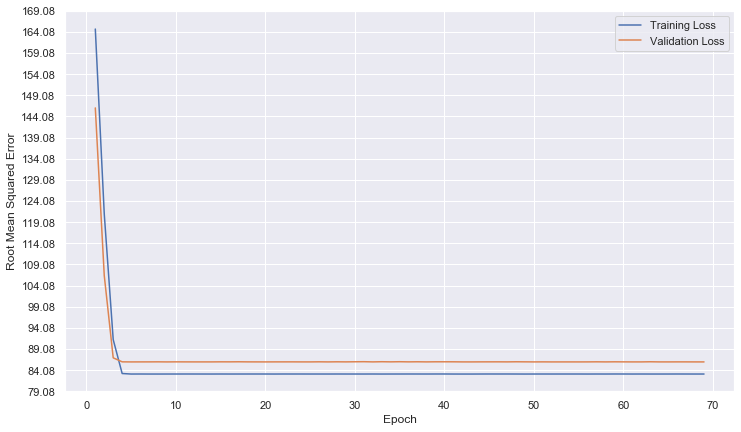

In [12]:
### Task 3 - Fixing The Problem.
shuffled_train_df = train_df.reindex(np.random.permutation(train_df.index))
evaluate(shuffled_train_df, ["median_income"], "median_house_value", 0.08, 70, 100, .2)

#### Evaluating Model Performance

Train on 13600 samples, validate on 3400 samples
Epoch 1/10
13600/13600 [==============================] - 0s 32us/sample - loss: 41790.0353 - root_mean_squared_error: 204.4261 - val_loss: 34107.6697 - val_root_mean_squared_error: 184.6826
Epoch 2/10
13600/13600 [==============================] - 0s 11us/sample - loss: 24254.6202 - root_mean_squared_error: 155.7390 - val_loss: 18905.1736 - val_root_mean_squared_error: 137.4961
Epoch 3/10
13600/13600 [==============================] - 0s 10us/sample - loss: 12971.3916 - root_mean_squared_error: 113.8920 - val_loss: 10117.9717 - val_root_mean_squared_error: 100.5881
Epoch 4/10
13600/13600 [==============================] - 0s 13us/sample - loss: 7747.8784 - root_mean_squared_error: 88.0220 - val_loss: 7447.1488 - val_root_mean_squared_error: 86.2969
Epoch 5/10
13600/13600 [==============================] - 0s 12us/sample - loss: 6920.0812 - root_mean_squared_error: 83.1870 - val_loss: 7406.8706 - val_root_mean_squared_error: 86.0632
Epoc

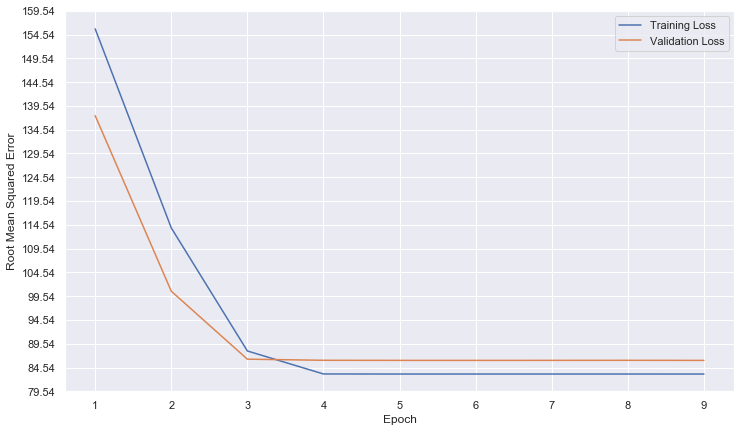

3000/3000 [==============================] - 0s 10us/sample - loss: 7012.6076 - root_mean_squared_error: 83.7413
************************
Test Results
************************
Loss: 7012.607633463542,
RMSE: 83.7413101196289
************************


In [13]:
evaluate(shuffled_train_df, ["median_income"], "median_house_value", 0.08, 10, 100, .2, True, test_df)

#### Creating Syntetic Data

To do this, we need to know what our features mean exactly.

1. **longitude:** A measure of how far west a house is; a higher value is farther west
2. **latitude:** A measure of how far north a house is; a higher value is farther north
3. **housing_median_age:** Median age of a house within a block; a lower number is a newer building
4. **total_rooms:** Total number of rooms within a block
5. **total_bedrooms:** Total number of bedrooms within a block
6. **population:** Total number of people residing within a block
7. **households:** Total number of households, a group of people residing within a home unit, for a block
8. **median_income:** Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. **median_house_value:** Median house value for households within a block (measured in US Dollars)

We'll create some syntetic features and check those if they worked well or not.
* The first feature will be the **rooms_per_person** = **total_rooms** / **population**
* Assuming that the income is normally distributed. the median will be equal to mean. By applying this assumption we can calculate **mean_income_per_person** = (**households** x **median_income**) / **population**
* By summing the **total_rooms** and **total_bedrooms** we can calculate the **absolute_total_rooms**
    - by dividing this to **population** we can calculate the **absolute_rooms_per_person**
    - by dividing this to **households** we can calculate the **absolute_rooms_per_house**

In [17]:
### Creating Features
combined_set = [train_df, test_df]

for df in combined_set:
    df["rooms_per_person"] = df["total_rooms"]/df["population"]
    df["mean_income_per_person"] = (df["households"]*df["median_income"])/df["population"]
    df["absolute_total_rooms"] = df["total_rooms"] + df["total_bedrooms"]
    df["absolute_rooms_per_persom"] = df["absolute_total_rooms"] / df["population"]
    df["absolute_rooms_per_house"] = df["absolute_total_rooms"] / df["households"]   

In [21]:
train_df.corr()["median_house_value"].sort_values(ascending=False)

median_house_value           1.00
mean_income_per_person       0.75
median_income                0.69
rooms_per_person             0.21
absolute_rooms_per_persom    0.19
                             ... 
households                   0.06
total_bedrooms               0.05
population                  -0.03
longitude                   -0.04
latitude                    -0.14
Name: median_house_value, Length: 14, dtype: float64

Train on 14110 samples, validate on 2890 samples
Epoch 1/25
14110/14110 [==============================] - 0s 33us/sample - loss: 51734.9684 - root_mean_squared_error: 227.4532 - val_loss: 48921.1084 - val_root_mean_squared_error: 221.1812
Epoch 2/25
14110/14110 [==============================] - 0s 12us/sample - loss: 44464.9909 - root_mean_squared_error: 210.8673 - val_loss: 41855.8560 - val_root_mean_squared_error: 204.5870
Epoch 3/25
14110/14110 [==============================] - 0s 11us/sample - loss: 37857.1821 - root_mean_squared_error: 194.5692 - val_loss: 35461.8633 - val_root_mean_squared_error: 188.3132
Epoch 4/25
14110/14110 [==============================] - 0s 12us/sample - loss: 31905.1976 - root_mean_squared_error: 178.6203 - val_loss: 29697.5081 - val_root_mean_squared_error: 172.3297
Epoch 5/25
14110/14110 [==============================] - 0s 12us/sample - loss: 26561.9611 - root_mean_squared_error: 162.9784 - val_loss: 24574.7265 - val_root_mean_squared_error: 156.7

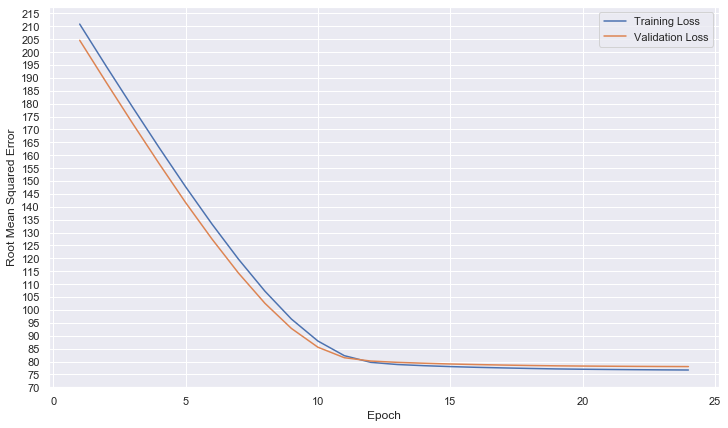

3000/3000 [==============================] - 0s 25us/sample - loss: 6031.2643 - root_mean_squared_error: 77.6612
************************
Test Results
************************
Loss: 6031.264314778646,
RMSE: 77.66121673583984
************************


In [34]:
shuffled_train_df = train_df.reindex(np.random.permutation(train_df.index))
evaluate(shuffled_train_df, ["mean_income_per_person"], "median_house_value", 0.05, 25, 100, .17, True, test_df)

As we can see now, we have better results with the **mean_income_per_person**.

---